# Regression Tabular Model for Kaggle Playground Series Season 3 Episode 1 Using Python and Scikit-Learn
### David Lowe
### January 16, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Playground Series Season 3 Episode 1 Dataset is a regression modeling situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions to give the Kaggle community a variety of reasonably lightweight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The dataset for this competition was generated from a deep learning model trained on the California Housing Dataset. Feature distributions are close to but different from the original.

ANALYSIS: The average performance of the machine learning algorithms achieved an RMSE benchmark of 0.5962 after preliminary training runs. Furthermore, we selected Extra Trees Regressor as the final model as it processed the training dataset with an RMSE score of 0.3379. When we tested the final model using the test dataset, the model achieved an RMSE score of 0.6114.

CONCLUSION: In this iteration, the Extra Trees model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Playground Series Season 3, Episode 1

Dataset ML Model: Regression with numerical features

Dataset Reference: https://www.kaggle.com/competitions/playground-series-s3e1

One source of potential performance benchmarks: https://www.kaggle.com/competitions/playground-series-s3e1/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import datasets

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'MedHouseVal'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'neg_mean_squared_error'

# Define the directory locations and file names
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e01/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e01/test.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e01/sample_submission.csv'
SUBMISSION_FILE = 'submission_sklearn_'

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0   0  2.3859      15.0  3.827160   1.112100      1280.0  2.486989     34.60   
1   1  3.7188      17.0  6.013373   1.054217      1504.0  3.813084     38.69   
2   2  4.7750      27.0  6.535604   1.103175      1061.0  2.464602     34.71   
3   3  2.4138      16.0  3.350203   0.965432      1255.0  2.089286     32.66   
4   4  3.7500      52.0  4.284404   1.069246      1793.0  1.604790     37.80   

   Longitude  MedHouseVal  
0    -120.12        0.980  
1    -121.22        0.946  
2    -120.45        1.576  
3    -117.09        1.336  
4    -122.41        4.500  


In [8]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37137 entries, 0 to 37136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37137 non-null  int64  
 1   MedInc       37137 non-null  float64
 2   HouseAge     37137 non-null  float64
 3   AveRooms     37137 non-null  float64
 4   AveBedrms    37137 non-null  float64
 5   Population   37137 non-null  float64
 6   AveOccup     37137 non-null  float64
 7   Latitude     37137 non-null  float64
 8   Longitude    37137 non-null  float64
 9   MedHouseVal  37137 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.8 MB


In [9]:
print(df_dataset_import.describe())

                id        MedInc      HouseAge      AveRooms     AveBedrms  \
count  37137.00000  37137.000000  37137.000000  37137.000000  37137.000000   
mean   18568.00000      3.851029     26.057005      5.163124      1.062204   
std    10720.67281      1.803167     12.158221      1.206242      0.096490   
min        0.00000      0.499900      2.000000      0.851064      0.500000   
25%     9284.00000      2.602300     17.000000      4.357522      1.020305   
50%    18568.00000      3.515600     25.000000      5.068611      1.054545   
75%    27852.00000      4.699700     35.000000      5.858597      1.088825   
max    37136.00000     15.000100     52.000000     28.837607      5.873181   

         Population      AveOccup      Latitude     Longitude   MedHouseVal  
count  37137.000000  37137.000000  37137.000000  37137.000000  37137.000000  
mean    1660.778919      2.831243     35.570030   -119.554329      2.079751  
std     1302.469608      2.702413      2.083179      1.974028  

In [10]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [11]:
def convert_latitude(target_col):
    # print(target_col)
    latitude_loc = 'A' + str(int(target_col)).zfill(3)
    return latitude_loc

def convert_longitude(target_col):
    # print(target_col)
    longitude_loc = 'G' + str(int(target_col)).zfill(3)
    return longitude_loc

In [12]:
# Fetch the original Scikit-learn training dataset with more attributes
df_dataset_sklearn = datasets.fetch_california_housing(as_frame=True)['data']
df_dataset_sklearn['MedHouseVal'] = datasets.fetch_california_housing(as_frame=True)['target']
df_dataset_sklearn['is_synthetic'] = 0

df_dataset_sklearn.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MedInc        20640 non-null  float64
 1   HouseAge      20640 non-null  float64
 2   AveRooms      20640 non-null  float64
 3   AveBedrms     20640 non-null  float64
 4   Population    20640 non-null  float64
 5   AveOccup      20640 non-null  float64
 6   Latitude      20640 non-null  float64
 7   Longitude     20640 non-null  float64
 8   MedHouseVal   20640 non-null  float64
 9   is_synthetic  20640 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.6 MB


In [13]:
# Combine the original and synthetic datasets into one training dataset
df_dataset_import['is_synthetic'] = 1
df_dataset_import.drop(columns=['id'], inplace=True)
df_dataset_import = pd.concat([df_dataset_import, df_dataset_sklearn],
                              ignore_index=True)

df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57777 entries, 0 to 57776
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MedInc        57777 non-null  float64
 1   HouseAge      57777 non-null  float64
 2   AveRooms      57777 non-null  float64
 3   AveBedrms     57777 non-null  float64
 4   Population    57777 non-null  float64
 5   AveOccup      57777 non-null  float64
 6   Latitude      57777 non-null  float64
 7   Longitude     57777 non-null  float64
 8   MedHouseVal   57777 non-null  float64
 9   is_synthetic  57777 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 4.4 MB


In [14]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Encode geolocations
lat_est = preprocessing.KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
df_dataset_import['LatKBins'] = lat_est.fit_transform(df_dataset_import['Latitude'].to_numpy().reshape(-1, 1))
long_est = preprocessing.KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
df_dataset_import['LongKBins'] = long_est.fit_transform(df_dataset_import['Longitude'].to_numpy().reshape(-1, 1))

df_dataset_import['Lat_Loc'] = df_dataset_import['LatKBins'].apply(convert_latitude)
df_dataset_import['Long_Loc'] = df_dataset_import['LongKBins'].apply(convert_longitude)

# Dropping unique identifier and unnecessary features
df_dataset_import.drop(columns=['Latitude','Longitude','LatKBins','LongKBins'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())
print(df_dataset_import.tail())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  target  \
0  2.3859      15.0  3.827160   1.112100      1280.0  2.486989   0.980   
1  3.7188      17.0  6.013373   1.054217      1504.0  3.813084   0.946   
2  4.7750      27.0  6.535604   1.103175      1061.0  2.464602   1.576   
3  2.4138      16.0  3.350203   0.965432      1255.0  2.089286   1.336   
4  3.7500      52.0  4.284404   1.069246      1793.0  1.604790   4.500   

   is_synthetic Lat_Loc Long_Loc  
0             1    A021     G042  
1             1    A065     G031  
2             1    A023     G038  
3             1    A001     G072  
4             1    A055     G019  
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  target  \
57772  1.5603      25.0  5.045455   1.133333       845.0  2.560606   0.781   
57773  2.5568      18.0  6.114035   1.315789       356.0  3.122807   0.771   
57774  1.7000      17.0  5.205543   1.120092      1007.0  2.325635   0.923   
57775  1.8672      18.0  5.329513

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57777 entries, 0 to 57776
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MedInc        57777 non-null  float64
 1   HouseAge      57777 non-null  float64
 2   AveRooms      57777 non-null  float64
 3   AveBedrms     57777 non-null  float64
 4   Population    57777 non-null  float64
 5   AveOccup      57777 non-null  float64
 6   target        57777 non-null  float64
 7   is_synthetic  57777 non-null  int64  
 8   Lat_Loc       57777 non-null  object 
 9   Long_Loc      57777 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 4.4+ MB


In [16]:
print(df_dataset_import.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  57777.000000  57777.000000  57777.000000  57777.000000  57777.000000   
mean       3.858046     26.979559      5.258104      1.074519   1576.720610   
std        1.838287     12.374508      1.771502      0.294086   1249.494223   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.588200     17.000000      4.381443      1.015306    882.000000   
50%        3.521400     26.000000      5.126761      1.052941   1316.000000   
75%        4.710900     36.000000      5.936031      1.091837   1815.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup        target  is_synthetic  
count  57777.000000  57777.000000  57777.000000  
mean       2.916770      2.075753      0.642764  
std        6.575793      1.156927      0.479189  
min        0.692308      0.149990      0.000000  
25%        2.407625      1.203000     

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

MedInc          0
HouseAge        0
AveRooms        0
AveBedrms       0
Population      0
AveOccup        0
target          0
is_synthetic    0
Lat_Loc         0
Long_Loc        0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (57777, 10) df_features_train.shape: (57777, 9) df_target_train.shape: (57777,)


### 1.f) Set up the parameters for data visualization

In [19]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [20]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [21]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

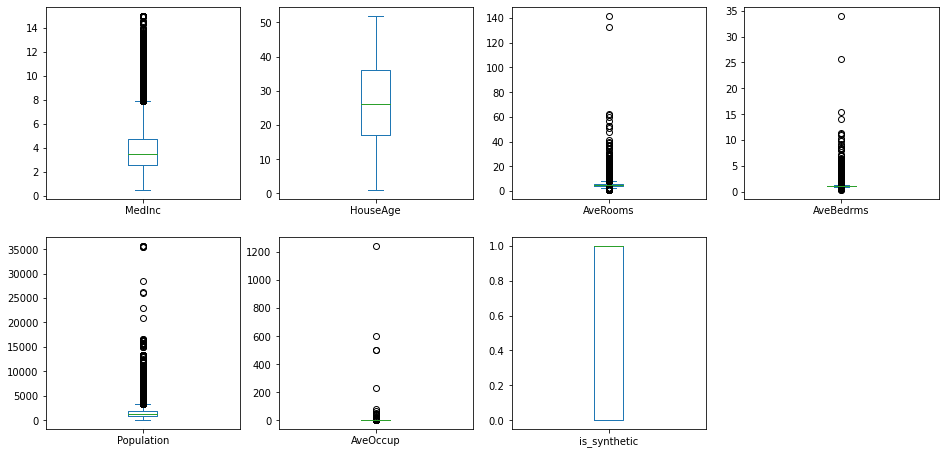

In [22]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

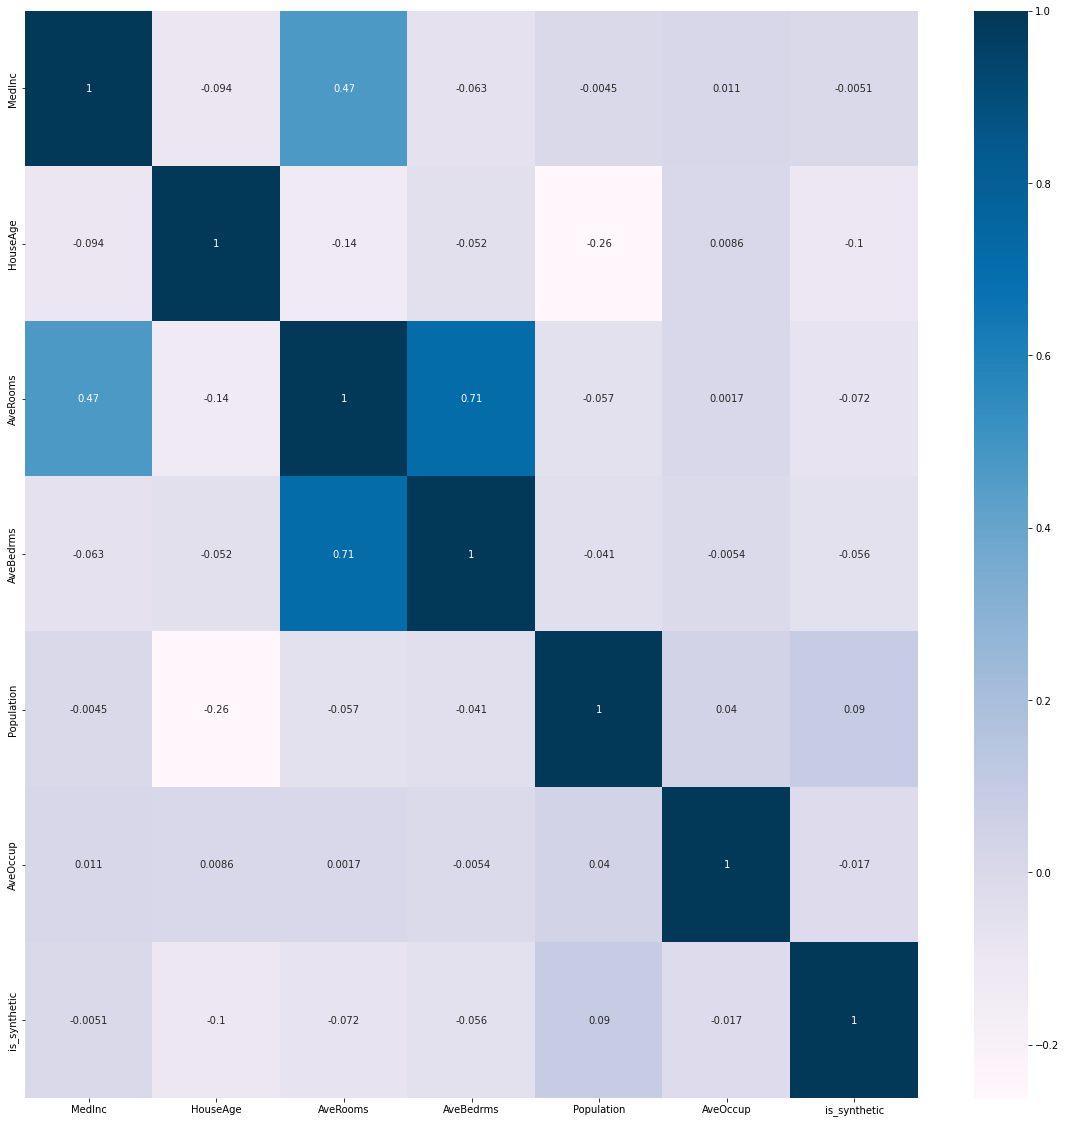

In [23]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [25]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [26]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    # ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 7
Number of categorical columns: 2
Total number of columns in the feature dataframe: 9


In [27]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

### 3.b) Training Data Balancing

In [28]:
# Not applicable for this iteration of modeling

### 3.c) Feature Selection

In [29]:
# Not applicable for this iteration of modeling

### 3.d) Display the Final Datasets for Model-Building

In [30]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
array_target_train = df_target_train.to_numpy()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (57777, 204) array_target_train.shape: (57777,)


In [31]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [32]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [33]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [34]:
train_models.append(('LNR', LinearRegression(n_jobs=N_JOBS)))
train_models.append(('ELN', ElasticNet(random_state=RNG_SEED)))
train_models.append(('CART', DecisionTreeRegressor(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsRegressor(n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [35]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LNR: -0.431607 (0.008403)
LinearRegression(n_jobs=2)
Model training time: 0:00:08.678651 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


ELN: -0.773537 (0.012749)
ElasticNet(random_state=888)
Model training time: 0:00:01.755995 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   17.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: -0.736842 (0.022712)
DecisionTreeRegressor(random_state=888)
Model training time: 0:00:17.787288 



/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KNN: -0.910432 (0.009015)
KNeighborsRegressor(n_jobs=2)
Model training time: 0:01:42.764879 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  6.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: -0.384577 (0.005543)
RandomForestRegressor(n_jobs=2, random_state=888)
Model training time: 0:06:45.815936 

EXT: -0.340483 (0.004324)
ExtraTreesRegressor(n_jobs=2, random_state=888)
Model training time: 0:11:08.654621 

Average metrics (neg_mean_squared_error) from all models: -0.596246160052685
Total training time for all models: 0:20:05.489430


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 11.1min finished


### 4.b) Spot-checking baseline algorithms

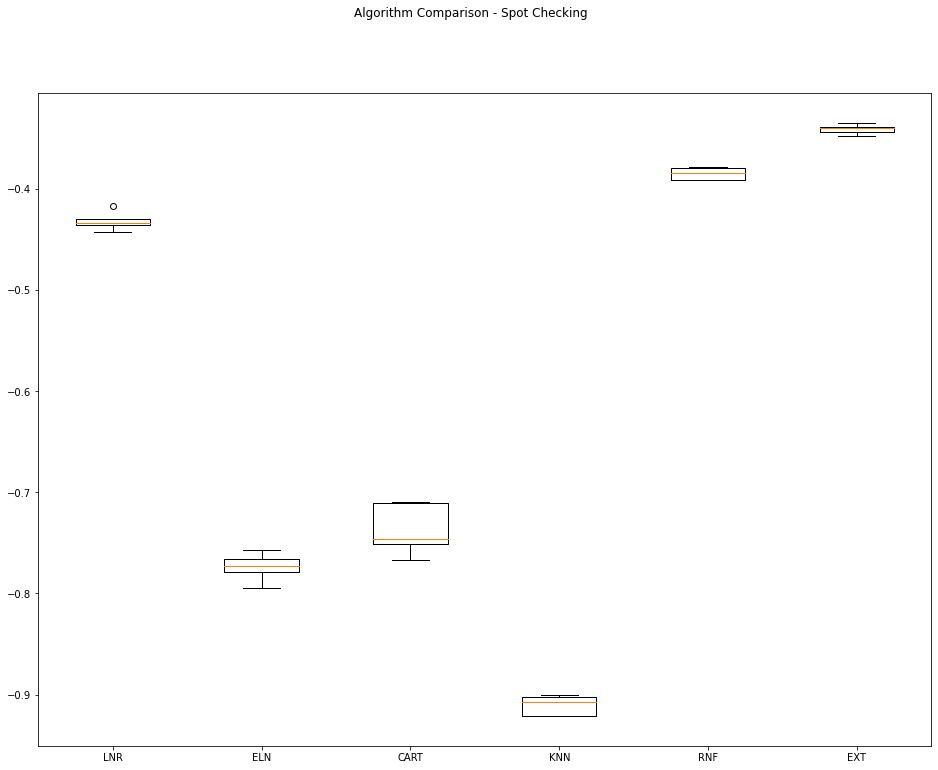

In [36]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Algorithm Tuning

In [38]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [39]:
# Tuning algorithm #1
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ElasticNet(random_state=RNG_SEED)
tune_model_names.append('ELN')
paramGrid1 = dict(l1_ratio=np.array([0, 0.25, 0.5, 0.75, 1]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: -0.675405 using {'l1_ratio': 0.0}
-0.675405 (0.009434) with: {'l1_ratio': 0.0}
-0.720421 (0.011247) with: {'l1_ratio': 0.25}
-0.773537 (0.012749) with: {'l1_ratio': 0.5}
-0.851993 (0.015227) with: {'l1_ratio': 0.75}
-0.965620 (0.019224) with: {'l1_ratio': 1.0}
Model training time: 0:02:33.312284


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e+04, tolerance: 7.733e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [40]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: l1_ratio = 0.0


In [41]:
# Tuning algorithm #2
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('EXT')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: -0.337989 using {'n_estimators': 500}
-0.340483 (0.004324) with: {'n_estimators': 100}
-0.338543 (0.004046) with: {'n_estimators': 300}
-0.337989 (0.004255) with: {'n_estimators': 500}
Model training time: 1:56:10.975915


In [42]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 500


### 4.d) Compare Algorithms After Tuning

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


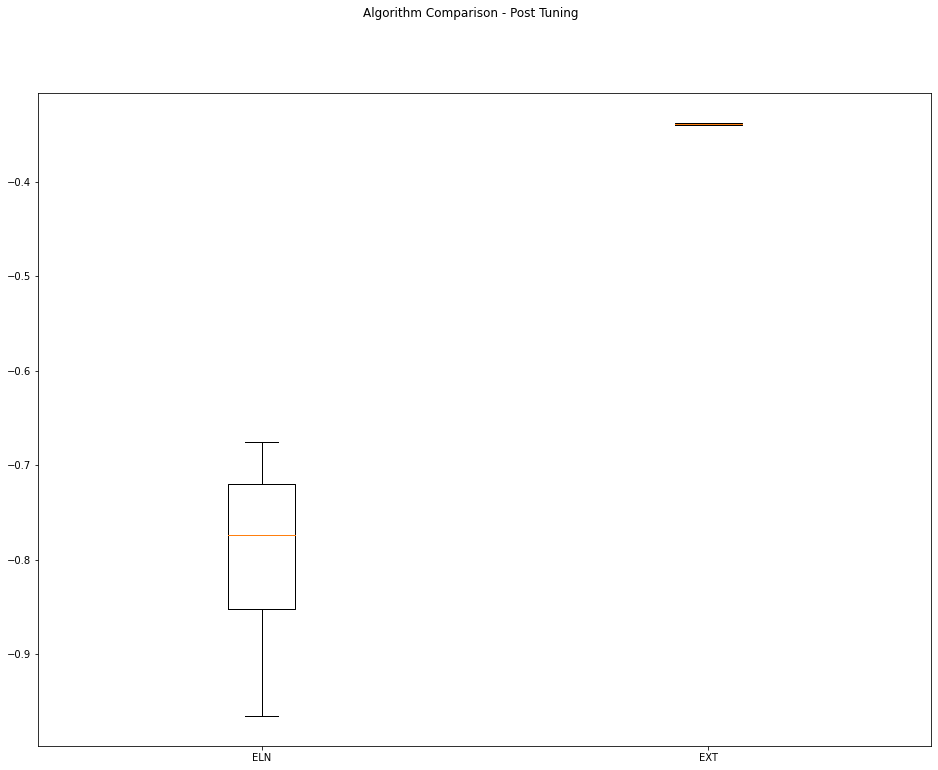

In [43]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [45]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [46]:
start_time_module = datetime.now()
FINAL_PARAMETER = 500
final_model = ExtraTreesRegressor(n_estimators=FINAL_PARAMETER, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)
print ('Model training time:', (datetime.now() - start_time_module))

ExtraTreesRegressor(n_estimators=500, n_jobs=2, random_state=888)
Model training time: 0:17:30.798357


### 5.b) Load Test Dataset and Make Predictions

In [47]:
df_features_test = pd.read_csv(TEST_DATASET)
df_features_test['is_synthetic'] = 1

# Encode geolocations
df_features_test['LatKBins'] = lat_est.transform(df_features_test['Latitude'].to_numpy().reshape(-1, 1))
df_features_test['LongKBins'] = long_est.transform(df_features_test['Longitude'].to_numpy().reshape(-1, 1))

df_features_test['Lat_Loc'] = df_features_test['LatKBins'].apply(convert_latitude)
df_features_test['Long_Loc'] = df_features_test['LongKBins'].apply(convert_longitude)

# Dropping unique identifier and unnecessary features
df_features_test.drop(columns=['Latitude','Longitude','LatKBins','LongKBins'], inplace=True)

# Take a peek at the dataframe after import
print(df_features_test.head())

      id  MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
0  37137  1.7062      35.0  4.966368   1.096539      1318.0  2.844411   
1  37138  1.3882      22.0  4.187035   1.098229      2296.0  3.180218   
2  37139  7.7197      21.0  7.129436   0.959276      1535.0  2.888889   
3  37140  4.6806      49.0  4.769697   1.048485       707.0  1.743590   
4  37141  3.1284      25.0  3.765306   1.081633      4716.0  2.003827   

   is_synthetic Lat_Loc Long_Loc  
0             1    A076     G024  
1             1    A014     G060  
2             1    A011     G065  
3             1    A017     G059  
4             1    A017     G060  


In [48]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

      id
0  37137
1  37138
2  37139
3  37140
4  37141


In [49]:
# Dropping unique identifier and unnecessary features
df_features_test.drop(columns=[id_column_name,], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  is_synthetic  \
0  1.7062      35.0  4.966368   1.096539      1318.0  2.844411             1   
1  1.3882      22.0  4.187035   1.098229      2296.0  3.180218             1   
2  7.7197      21.0  7.129436   0.959276      1535.0  2.888889             1   
3  4.6806      49.0  4.769697   1.048485       707.0  1.743590             1   
4  3.1284      25.0  3.765306   1.081633      4716.0  2.003827             1   

  Lat_Loc Long_Loc  
0    A076     G024  
1    A014     G060  
2    A011     G065  
3    A017     G059  
4    A017     G060  


In [50]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (24759, 9) to array_features_test.shape: (24759, 204)


In [51]:
# Make batched predictions
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

[0.79352    0.963106   3.7151745  ... 1.114702   3.17744608 3.86140652]


In [52]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

MedHouseVal


In [53]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

      id  MedHouseVal
0  37137     0.793520
1  37138     0.963106
2  37139     3.715174
3  37140     3.459644
4  37141     2.387594


In [54]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_sklearn_20230115-1925.csv


In [55]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [56]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 2:36:31.956802
